## Draft

In [ ]:
#create pool of conformers
#minimize
#calculate energy
#output - dictionary with molecule:{conformer id: [energy, [coordinates of atom]],...}; data with dropped molecules
#which can't be preprocessed by mmff (only organic)

def conformers_calc(data, elements, numConfs=3):
    conformers_calc={}
    data_length=len(data['smiles_no_salt'])
    
    for i,smile in enumerate(data['smiles_no_salt']):
        molecule=Chem.MolFromSmiles(smile)
        molecule=Chem.AddHs(molecule)
        
        AllChem.EmbedMultipleConfs(molecule, numConfs=numConfs, pruneRmsThresh=-1.)
        conf_calc={}
        
        try:
            for conformer in molecule.GetConformers():
                
                AllChem.MMFFSanitizeMolecule(molecule)
                #unversal force field - uff
                #mmff - only for organic
                mmff_props=AllChem.MMFFGetMoleculeProperties(molecule)
                ff=AllChem.MMFFGetMoleculeForceField(molecule,mmff_props,confId=conformer.GetId())
                ff.Minimize()
                energy = ff.CalcEnergy()
                
                rdmt.CanonicalizeConformer(molecule.GetConformer(id=conformer.GetId()))
                xyz = [(lambda atom, pos: [atom.GetSymbol(),pos.x, pos.y, pos.z])(
            molecule.GetAtomWithIdx(i), molecule.GetConformer(id=conformer.GetId()).GetAtomPosition(i))
                         for i in range(molecule.GetNumAtoms())]
                xyz_dict={}
                
                for elem in xyz:
                    atom=elem[0]
                    x,y,z=(elem[1],elem[2],elem[3])
                    if atom in elements.keys():
                        if atom in xyz_dict.keys():
                            xyz_dict[atom].append((x,y,z))
                        else:
                            xyz_dict[atom]=[(x,y,z)]
                xyz=xyz_dict
                
                conf_calc[conformer.GetId()]=[energy,xyz]
                
            if conf_calc!={}:
                conf_calc=possibility_norm(conf_calc, a=1)
                conformers_calc[smile]=conf_calc
            else: 
                raise Exception('no conformers')
                
        except:
            print(smile," has some problems")
            data=data.drop(index=i,axis=0)
            #just drop (leave only organic)
            
        if i%100==0:
            print ('molecule %d / %d' % (i,data_length))
            
    return conformers_calc, data

In [29]:
data=data[:100]
start_time = time.time()
numConfs=NUM_CONFS
smiles=list(data['smiles_no_salt'])
p = mp.Pool(processes=4)

def f_confs(smile):
    
    molecule=Chem.MolFromSmiles(smile)
    molecule=Chem.AddHs(molecule)
    AllChem.EmbedMultipleConfs(molecule, numConfs,maxAttempts=10000, pruneRmsThresh=-1)
    conformers=molecule.GetConformers()
    confIds=[conf.GetId() for conf in conformers]
    try:
        AllChem.MMFFSanitizeMolecule(molecule)
    except:
        return None
    p_inner = mp.Pool(processes=4)
    def f_props(confId):
        try:
#             AllChem.MMFFSanitizeMolecule(molecule)
            #unversal force field - uff
            #mmff - only for organic
            mmff_props=AllChem.MMFFGetMoleculeProperties(molecule)
            ff=AllChem.MMFFGetMoleculeForceField(molecule,mmff_props,confId=confId)
            ff.Minimize()
            energy = ff.CalcEnergy()
            rdmt.CanonicalizeConformer(molecule.GetConformer(id=confId))
            xyz = [(lambda atom, pos: [atom.GetSymbol(),pos.x, pos.y, pos.z])(
            molecule.GetAtomWithIdx(i), molecule.GetConformer(id=confId).GetAtomPosition(i))
                         for i in range(molecule.GetNumAtoms())]
            xyz_dict={}

            for elem in xyz:
                atom=elem[0]
                x,y,z=(elem[1],elem[2],elem[3])
                if atom in elements.keys():
                    if atom in xyz_dict.keys():
                        xyz_dict[atom].append((x,y,z))
                    else:
                        xyz_dict[atom]=[(x,y,z)]
        except:
#             print ('can\'t get conformers')
            return
        xyz=xyz_dict
        return[energy,xyz]
    def f_possibility_norm(props, a=1):
        from math import exp
        try:
            energies=[x[0] for x in props]
        except:
            print(len(props))
            return props
        norm=max(energies)
        for i in range(len(props)):
            props[i][0]/=norm
            props[i][0]=exp(-a*props[i][0])
        energies=[x[0] for x in props]
        norm=sum(energies)
        for i in range(len(props)):
            props[i][0]/=norm
        return props
    props=p_inner.map(f_props,confIds)
    props=f_possibility_norm(props)
    p_inner.close()
    p_inner.join()
    props_dict=dict(zip(confIds,props))
    return props_dict     

# molecules=p.map(f_smile, smiles)
properties = p.map(f_confs, smiles)
conf_calc=dict(zip(smiles,properties))
print("--- %s seconds ---" % (time.time() - start_time))
# print(conf_calc)
p.close()
p.join()

--- 62.234559535980225 seconds ---


In [ ]:
#create elements dictionary
elements=create_element_dict(data,amount=AMOUNT_OF_ELEM)

del_keys_list=[]
parts_amount=int(len(data)/DATA_SIZE)
end_num=-1
for i in range(parts_amount-1):
    start_time = time.time()
    data_input=data[i*DATA_SIZE:(i+1)*DATA_SIZE]
    conf_calc, del_keys, end_num=conf_calc_pool(data_input,elements,numConfs=NUM_CONFS,proc_num=NUM_PROC,start_num=end_num+1)
    del_keys_list.append(del_keys)
    dd.io.save('tox_augmented'+str(i)+'.h5', conf_calc)
    print('made ',(i+1)*DATA_SIZE,'/',len(data),' in ',time.time() - start_time,' sec')
data_input=data[(i+1)*DATA_SIZE:]
conf_calc, del_keys=conf_calc_pool(data_input,elements,numConfs=NUM_CONFS,proc_num=NUM_PROC,start_num=end_num+1)
del_keys_list.append(del_keys)
dd.io.save('tox_augmented'+str(i)+'.h5', conf_calc)
for del_keys in del_keys_list:
    data=data_clean(data,del_keys)
#create dictionary with labels
label_dict= create_labels_dict(data)

--- 8 processes 21.5930233001709 seconds ---


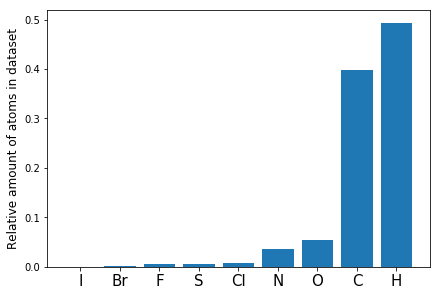

In [123]:
#calculate conformers,energy and coordinates for molecules
data=data[:100]
#create elements dictionary
elements=create_element_dict(data,amount=AMOUNT_OF_ELEM)
# conf_calc,del_keys=conf_calc_pool(data,elements,numConfs=NUM_CONFS,proc_num=NUM_PROC)
start_time = time.time()
# conf_calc1,_=conformers_calc(data,elements,numConfs=NUM_CONFS)
# print("--- 1 process %s seconds ---" % (time.time() - start_time))
start_time = time.time()
conf_calc, del_keys=conf_calc_pool(data,elements,numConfs=NUM_CONFS,proc_num=NUM_PROC)
dd.io.save('test.h5', conf_calc)
print("--- %d processes %s seconds ---" % (NUM_PROC,(time.time() - start_time)))
data=data_clean(data,del_keys)
#create dictionary with labels
label_dict= create_labels_dict(data)
#create dictionary indexies:smiles
indexing = pd.read_csv("id_smiles.csv")

In [66]:
d = {'foo': {'bar': np.arange(10), 'baz': np.zeros(3)}, 'qux': np.ones(12)}
dd.io.save('test.h5', d)

In [122]:
!python -m deepdish.io.ls test.h5 

/smiles0                   dict
/smiles0/conformer0        dict
/smiles0/conformer0/coo... dict
/smiles0/conformer0/coo... array (14, 3) [float64]
/smiles0/conformer0/coo... array (14, 3) [float64]
/smiles0/conformer0/coo... array (3, 3) [float64]
/smiles0/conformer0/ene... 55.05482960525459 [float64]
/smiles0/conformer1        dict
/smiles0/conformer1/coo... dict
/smiles0/conformer1/coo... array (14, 3) [float64]
/smiles0/conformer1/coo... array (14, 3) [float64]
/smiles0/conformer1/coo... array (3, 3) [float64]
/smiles0/conformer1/ene... 53.110162361079965 [float64]
/smiles0/conformer2        dict
/smiles0/conformer2/coo... dict
/smiles0/conformer2/coo... array (14, 3) [float64]
/smiles0/conformer2/coo... array (14, 3) [float64]
/smiles0/conformer2/coo... array (3, 3) [float64]
/smiles0/conformer2/ene... 54.92077454422281 [float64]
/smiles1                   dict
/smiles1/conformer0        dict
/smiles1/conformer0/coo... dict
/smiles1/conformer0/coo... array (4, 3) [float64]
/smiles1

/smiles54/conformer2/co... array (2, 3) [float64]
/smiles54/conformer2/co... array (1, 3) [float64]
/smiles54/conformer2/co... array (1, 3) [float64]
/smiles54/conformer2/en... 196.05372494473812 [float64]
/smiles55                  dict
/smiles55/conformer0       dict
/smiles55/conformer0/co... dict
/smiles55/conformer0/co... array (24, 3) [float64]
/smiles55/conformer0/co... array (1, 3) [float64]
/smiles55/conformer0/co... array (1, 3) [float64]
/smiles55/conformer0/co... array (26, 3) [float64]
/smiles55/conformer0/co... array (4, 3) [float64]
/smiles55/conformer0/co... array (1, 3) [float64]
/smiles55/conformer0/en... 25.30859945193317 [float64]
/smiles55/conformer1       dict
/smiles55/conformer1/co... dict
/smiles55/conformer1/co... array (24, 3) [float64]
/smiles55/conformer1/co... array (1, 3) [float64]
/smiles55/conformer1/co... array (1, 3) [float64]
/smiles55/conformer1/co... array (26, 3) [float64]
/smiles55/conformer1/co... array (4, 3) [float64]
/smiles55/conformer1/co..

/smiles91/conformer2/co... array (1, 3) [float64]
/smiles91/conformer2/en... 42.32789515210409 [float64]
/smiles92                  dict
/smiles92/conformer0       dict
/smiles92/conformer0/co... dict
/smiles92/conformer0/co... array (33, 3) [float64]
/smiles92/conformer0/co... array (38, 3) [float64]
/smiles92/conformer0/co... array (2, 3) [float64]
/smiles92/conformer0/co... array (8, 3) [float64]
/smiles92/conformer0/en... 82.5721532340523 [float64]
/smiles92/conformer1       dict
/smiles92/conformer1/co... dict
/smiles92/conformer1/co... array (33, 3) [float64]
/smiles92/conformer1/co... array (38, 3) [float64]
/smiles92/conformer1/co... array (2, 3) [float64]
/smiles92/conformer1/co... array (8, 3) [float64]
/smiles92/conformer1/en... 92.02592165313297 [float64]
/smiles92/conformer2       dict
/smiles92/conformer2/co... dict
/smiles92/conformer2/co... array (33, 3) [float64]
/smiles92/conformer2/co... array (38, 3) [float64]
/smiles92/conformer2/co... array (2, 3) [float64]
/smile

## Importing needed libraries

In [2]:
#import all the necessary libraries

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem import rdMolTransforms as rdmt
from rdkit.Chem import rdShapeHelpers as rdshp
import molvs as mv
from rdkit.Geometry import rdGeometry 
from matplotlib.pyplot import spy
import matplotlib.pyplot as plt
from scipy import signal

import torch
from torch.utils import data as td

import multiprocessing.dummy as mp
import multiprocessing

import time

import deepdish as dd

import sqlite3

In [3]:
#number of conformers created for every molecule
global NUM_CONFS
NUM_CONFS=100

#amount of chemical elements taking into account
global AMOUNT_OF_ELEM
AMOUNT_OF_ELEM=6

#amount of processes for parallelizing
global NUM_PROC
NUM_PROC=multiprocessing.cpu_count()

#amount of molecules in part of database
global DATA_SIZE
DATA_SIZE=1000

## Creating dataframe with molecules and properties

In [22]:
#function removing salts (leave the longest part of the molecule)

def del_salts(molecule):
    s=mv.standardize.Standardizer()
    stand_mol=s.fragment_parent(molecule)
    return stand_mol

In [23]:
#converting energiies in possibilities

def possibility_norm(conf_calc, a=1):
    from math import exp
    
    if conf_calc=={}:
        return conf_calc
    
    energies=[x[0] for x in conf_calc.values()]
    norm=max(energies)
    
    for key in conf_calc.keys():
        conf_calc[key][0]/=norm
        conf_calc[key][0]=exp(-a*conf_calc[key][0])
        
    energies=[x[0] for x in conf_calc.values()]
    norm=sum(energies)
    
    for key in conf_calc.keys():
        conf_calc[key][0]/=norm
        
    return conf_calc

In [24]:
#create pandas dataframe fron sdf file

def create_dataset(filename):
    name=filename.split('.')[0]
    suppl = Chem.SDMolSupplier(filename)
    #the list of molecules
    dataset=[]
    
    for i,molecule in enumerate(suppl):
        try:
            row = {}
            
            #converting molecule from file to smile representation
            smile=Chem.MolToSmiles(molecule)
            row['smiles'] = smile
            
            #removing salts
            stand_mol=del_salts(molecule)
            smile_no_salt=Chem.MolToSmiles(stand_mol)
            row['smiles_no_salt'] = smile_no_salt
            
            #add properties from file
            for propname in molecule.GetPropNames():
                row[propname] = molecule.GetProp(propname)
            dataset.append(row)
        except:
            print ("Can't smile molecule ",i)

    data = pd.DataFrame(dataset)
    
    #drop useless info
    try:
        data=data.drop(columns=['DSSTox_CID','FW','Formula','Unnamed:\n0'])
    except:
        data=data.drop(columns=['DSSTox_CID','FW','Formula'])
    data.to_csv(name + '.csv',index=False)
    return data

In [25]:
#merging features of the same molecules

def merging_rows(row):
    row_without_nan=[x for x in row if x is not np.nan]
    
    if not row_without_nan:
        return np.nan
    
    if len(np.unique(row_without_nan))>1:
        return np.nan
    else:
        return row_without_nan[0]

In [26]:
#create unique "smiles_no_salt" values
#drop molecule if there is contradicted info
#merge nan and 0/1 values

def del_duplicates(data,filename):
    name=filename.split('.')[0]
    props=list(data)
    props.remove('smiles')
    props.remove('smiles_no_salt')
    
    data_grouped=pd.DataFrame(data['smiles_no_salt'])
    data_grouped=data_grouped.drop_duplicates()
    
    for prop in props:
        grouped_prop=data.groupby(by='smiles_no_salt')[prop].apply(merging_rows)
        grouped_prop=pd.DataFrame(grouped_prop)
        data_grouped=data_grouped.join(grouped_prop,on='smiles_no_salt')
        
    data_grouped=data_grouped.dropna(subset=props,how='all')
    data_grouped.to_csv(name + '_no_salts.csv',index=False)
    return data_grouped

In [27]:
#calculation of sparsity: amount of empty elements/all the elements
def sparsity(data):
    samples_num=max(data.count())
    sparse=0
    for number in data.count():
        if number<samples_num:
            sparse+=samples_num-number
    sparse/=samples_num*(len(data.count())-2)
    return sparse
    

In [33]:
filename = "tox21_10k_data_all.sdf"

#load dataset to dataframe
data=create_dataset(filename)

data.info()

Can't smile molecule  281
Can't smile molecule  4447
Can't smile molecule  5588
Can't smile molecule  7626
Can't smile molecule  10122
Can't smile molecule  11248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11758 entries, 0 to 11757
Data columns (total 14 columns):
NR-AR             9357 non-null object
NR-AR-LBD         8594 non-null object
NR-AhR            8164 non-null object
NR-Aromatase      7221 non-null object
NR-ER             7693 non-null object
NR-ER-LBD         8748 non-null object
NR-PPAR-gamma     8179 non-null object
SR-ARE            7164 non-null object
SR-ATAD5          9086 non-null object
SR-HSE            8146 non-null object
SR-MMP            7316 non-null object
SR-p53            8629 non-null object
smiles            11758 non-null object
smiles_no_salt    11758 non-null object
dtypes: object(14)
memory usage: 1.3+ MB


In [34]:
print('Sparsity of data is ', sparsity(data))

Sparsity of data is  0.303332482848557


In [35]:
#delete repeating molecules values
data=del_duplicates(data,filename)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7690 entries, 0 to 11757
Data columns (total 13 columns):
smiles_no_salt    7690 non-null object
NR-AR             7067 non-null object
NR-AR-LBD         6620 non-null object
NR-AhR            6379 non-null object
NR-Aromatase      5680 non-null object
NR-ER             5944 non-null object
NR-ER-LBD         6777 non-null object
NR-PPAR-gamma     6329 non-null object
SR-ARE            5672 non-null object
SR-ATAD5          6920 non-null object
SR-HSE            6307 non-null object
SR-MMP            5670 non-null object
SR-p53            6640 non-null object
dtypes: object(13)
memory usage: 841.1+ KB


In [36]:
print('Sparsity of data is ', sparsity(data))

Sparsity of data is  0.19239862867951293


## Preprocessing data into dictionary

In [4]:
#choosing conformer of molecule according to probability
#input - dictionary of molecule conformers and its properties {conformer id: [probability of choice,
#[coordinates of atom]],...}
#output - number of conformer

def conformer_choice(props):
    probabilities=[props[key]['energy'] for key in props.keys()]
    conformer=np.random.choice(range(len(props)),1,probabilities)
    return np.asscalar(conformer)

In [46]:
#create pool of conformers
#minimize
#calculate energy
#output - dictionary with molecule:{conformer id: [energy, [coordinates of atom]],...}; data with dropped molecules
#which can't be preprocessed by mmff (only organic)
#usage of pool multiprocessing

def conf_calc_pool(data,elements,numConfs=3,proc_num=4,start_num=0):
    def f_confs(smile):
        molecule=Chem.MolFromSmiles(smile)
        molecule=Chem.AddHs(molecule)
        AllChem.EmbedMultipleConfs(molecule, numConfs,maxAttempts=10000, pruneRmsThresh=-1)
        conformers=molecule.GetConformers()
        confIds=[conf.GetId() for conf in conformers]
        try:
            AllChem.MMFFSanitizeMolecule(molecule)
            mmff_props=AllChem.MMFFGetMoleculeProperties(molecule)
        except:
            return None
#         p_inner = mp.Pool(processes=proc_num)
        def f_props(confId):
            try:
                ff=AllChem.MMFFGetMoleculeForceField(molecule,mmff_props,confId=confId)
                ff.Minimize(maxIts=100)
            except:
                return None
            energy = ff.CalcEnergy()
            rdmt.CanonicalizeConformer(molecule.GetConformer(id=confId))
            xyz = [(lambda atom, pos: [atom.GetSymbol(),pos.x, pos.y, pos.z])(
            molecule.GetAtomWithIdx(i), molecule.GetConformer(id=confId).GetAtomPosition(i))
                         for i in range(molecule.GetNumAtoms())]
            xyz_dict={}
            for elem in xyz:
                atom=elem[0]
                x,y,z=(elem[1],elem[2],elem[3])
                if atom in elements.keys():
                    if atom in xyz_dict.keys():
                        xyz_dict[atom].append((x,y,z))
                    else:
                        xyz_dict[atom]=[(x,y,z)]
            xyz=xyz_dict
            for key in xyz_dict.keys():
                xyz_dict[key]=np.array(xyz_dict[key])
            return{'energy':np.array(energy),'coordinates':xyz}
        def f_possibility_norm(props, a=1):
            from math import exp
            try:
                energies=[x[0] for x in props]
            except:
                return props
            norm=max(energies)
            for i in range(len(props)):
                props[i][0]/=norm
                props[i][0]=exp(-a*props[i][0])
            energies=[x[0] for x in props]
            norm=sum(energies)
            for i in range(len(props)):
                props[i][0]/=norm
            return props
#         props=p_inner.map(f_props,confIds)
        props=list(map(f_props,confIds))
        props=f_possibility_norm(props)
#         p_inner.close()
#         p_inner.join()
        keys=['conformer'+str(i) for i in confIds]
        props_dict=dict(zip(keys,props))
        return props_dict     


    smiles=list(data['smiles_no_salt'])
    
    p = mp.Pool(processes=proc_num)
    #calculate energy and coordinates of conformers for each molecule
    properties = p.map(f_confs, smiles)
    p.close()
    p.join()
    conf_calc_smiles=dict(zip(smiles,properties))
    keys=list(conf_calc_smiles.keys())
    del_keys=[]
    for key in keys:
        if conf_calc_smiles[key]==None:
            del_keys.append(key)
            del conf_calc_smiles[key]
        else:
            for conf_num in conf_calc_smiles[key].keys():
                if conf_calc_smiles[key][conf_num]==None:
                    del_keys.append(key)
                    del conf_calc_smiles[key]
                    break
    keys=[]
    smiles=[]
    conf_calc={}
    for i,smile in enumerate(conf_calc_smiles.keys()):
        smiles.append(smile)
        keys.append('smiles'+str(i+start_num))
        conf_calc['smiles'+str(i+start_num)]=conf_calc_smiles[smile]
    df = pd.DataFrame({"id" : keys, "smiles" : smiles})
    df.to_csv("id_smiles"+str(int(start_num/DATA_SIZE))+".csv",index=False)    
    end_num=int(keys[-1][6:])
    return conf_calc,del_keys,end_num

In [47]:
#deleting elements with None props
def data_clean(data,del_keys):
    for key in del_keys:
        data=data[data.smiles_no_salt != key]
    return data

In [8]:
#define what chemical elements are used in molecules
#output - dictionary {element: number}
def create_element_dict(data,amount=AMOUNT_OF_ELEM,treshold=10):
    elements={}
    norm=0
    for smile in data['smiles_no_salt']:
        molecule=Chem.MolFromSmiles(smile)
        molecule=Chem.AddHs(molecule)
        
        for i in range(molecule.GetNumAtoms()):
            atom = molecule.GetAtomWithIdx(i)
            element=atom.GetSymbol()
            norm+=1
            if element in elements.keys():
                elements[element]+=1
            else:
                elements[element]=1
    for key in elements.keys():
        elements[key]/=norm
    from collections import OrderedDict
    dd = OrderedDict(sorted(elements.items(), key=lambda x: x[1]))
    
    fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharey=False, constrained_layout=True)
    axs.bar(list(dd.keys())[-amount:],list(dd.values())[-amount:])
    axs.set_ylabel('Relative amount of atoms in dataset',fontsize=12)
    axs.set_xticklabels(list(dd.keys())[-amount:],fontsize=15)

    elements=list(dd.keys())[-amount:]  
    elements=dict((elem,i) for i, elem in enumerate(elements))            
    return elements      

In [49]:
#creating dictionaty of labels {smile: {property name: index}}

def create_labels_dict(data):
    props=list(data)
    props.remove('smiles_no_salt')
    label_dict={}
    
    for (i,smile) in enumerate(data['smiles_no_salt']):
        labels={}
        for col in props:
            try:
                labels[col]=data.at[i,col]
            except: 
                labels[col]=np.nan
        label_dict[smile]=labels
        
    return label_dict

In [50]:
#write data to h5 database. Input - end_num - number of last written molecule (id(end_num)), parts_start - number of part 
#of data to start calculations

def creating_database(data, end_num=-1,parts_start=0):
    del_keys_list=[]
    parts_amount=int(len(data)/DATA_SIZE)
    for i in range(parts_start,parts_amount-1):
        start_time = time.time()
        data_input=data[i*DATA_SIZE:(i+1)*DATA_SIZE]
        conf_calc, del_keys, end_num=conf_calc_pool(data_input,elements,numConfs=NUM_CONFS,proc_num=NUM_PROC,start_num=end_num+1)
        del_keys_list.append(del_keys)
        dd.io.save('tox_augmented'+str(i)+'.h5', conf_calc)
        print('made ',(i+1)*DATA_SIZE,'/',len(data),' in ',time.time() - start_time,' sec')
    data_input=data[(i+1)*DATA_SIZE:]
    conf_calc, del_keys=conf_calc_pool(data_input,elements,numConfs=NUM_CONFS,proc_num=NUM_PROC,start_num=end_num+1)
    del_keys_list.append(del_keys)
    dd.io.save('tox_augmented'+str(i)+'.h5', conf_calc)
    for del_keys in del_keys_list:
        data=data_clean(data,del_keys)
    return data,parts_amount

In [5]:
#reading data from sql database
def reading_sql_database(filename='tox21_conformers.db'):
    conf_calc={}
    conn = sqlite3.connect(filename)
    c = conn.cursor()
    for row in c.execute('SELECT * FROM tox'):
        smile, conformer,energy,type_of_atom,x,y,z = row
        if smile in conf_calc.keys():
            if conformer in conf_calc[smile].keys():
                conf_calc[smile][conformer]['energy']=energy
                if 'coordinates' in conf_calc[smile][conformer].keys():
                    if type_of_atom in conf_calc[smile][conformer]['coordinates'].keys():
                        conf_calc[smile][conformer]['coordinates'][type_of_atom].append((x,y,z))
                    else:
                        conf_calc[smile][conformer]['coordinates'][type_of_atom]=[]
                else:
                    conf_calc[smile][conformer]['coordinates']={}
            else:
                conf_calc[smile][conformer]={}

        else:
            conf_calc[smile]={}
    conn.close()
    return conf_calc

In [51]:
#read data from h5 databases to dictionary

def reading_database(prefix_h5='tox_augmented',prefix_csv='id_smiles',file_num=3):
    conf_calc={}
    indexing={}
    for i in range(file_num):
        x=dd.io.load(prefix_h5+str(i)+'.h5')
        conf_calc = {**conf_calc, **x}
        y=pd.read_csv(prefix_csv+str(i)+'.csv')
        indexing = {**indexing, **y}
    return conf_calc, indexing

In [6]:
#get dataset without duplicates from csv
data=pd.read_csv('tox21_10k_data_all_no_salts.csv')

#create elements dictionary
elements=create_element_dict(data,amount=AMOUNT_OF_ELEM)

NameError: name 'create_element_dict' is not defined

In [ ]:
#creating files of database
data, parts_amount=creating_database(data, parts_start=2, end_num=1988)

#create dictionary with labels
label_dict= create_labels_dict(data)

In [8]:
#read databases to dictionary
conf_calc, indexing = reading_database(file_num=2)

C:\Users\Alice\Anaconda3\lib\site-packages\deepdish\io\hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


In [6]:
def indexing_label_dict(data,conf_calc):
    props=list(data)
    props.remove('smiles_no_salt')
    label_dict={}
    indexing={}
    for (i,smile) in enumerate(data['smiles_no_salt']):
        if smile in conf_calc.keys():
            labels=[]
            for col in props:
                try:
                    labels.append(data.at[i,col])
                except: 
                    labels[col]=np.nan
            label_dict[smile]=torch.tensor(labels)
            indexing[i]=smile
        
    return indexing, label_dict

Traceback (most recent call last):
  File "C:\Users\Alice\Anaconda3\lib\multiprocessing\queues.py", line 230, in _feed
    close()
  File "C:\Users\Alice\Anaconda3\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\Users\Alice\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] Неверный дескриптор
Traceback (most recent call last):
  File "C:\Users\Alice\Anaconda3\lib\multiprocessing\queues.py", line 230, in _feed
    close()
  File "C:\Users\Alice\Anaconda3\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\Users\Alice\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] Неверный дескриптор
Traceback (most recent call last):
Traceback (most recent call last):
  File "C:\Users\Alice\Anaconda3\lib\multiprocessing\queues.py", line 230, in _feed
    close()
  File "C:\Users\Alice\Anaconda3\lib

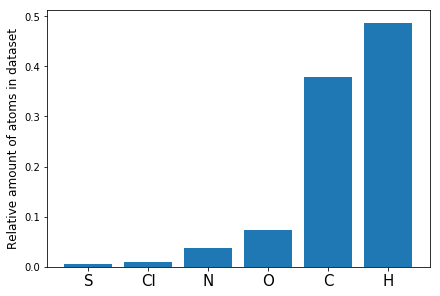

In [27]:
#get dataset without duplicates from csv
data=pd.read_csv('tox21_10k_data_all_no_salts.csv')

#create elements dictionary
elements=create_element_dict(data,amount=AMOUNT_OF_ELEM)

#read databases to dictionary
conf_calc=reading_sql_database()

#create indexing and label_dict for iteration
indexing,label_dict=indexing_label_dict(data,conf_calc)

In [10]:
del conf_calc

### Debugging

In [140]:
# df=pd.read_csv("id_smiles.csv")
df.at[df.index[df['id'] == 15][0],'smiles']
indexing = pd.read_csv("id_smiles.csv")

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 102
Data columns (total 13 columns):
smiles_no_salt    99 non-null object
NR-AR             80 non-null object
NR-AR-LBD         46 non-null object
NR-AhR            69 non-null object
NR-Aromatase      40 non-null object
NR-ER             34 non-null object
NR-ER-LBD         59 non-null object
NR-PPAR-gamma     34 non-null object
SR-ARE            27 non-null object
SR-ATAD5          53 non-null object
SR-HSE            73 non-null object
SR-MMP            40 non-null object
SR-p53            43 non-null object
dtypes: object(13)
memory usage: 13.3+ KB


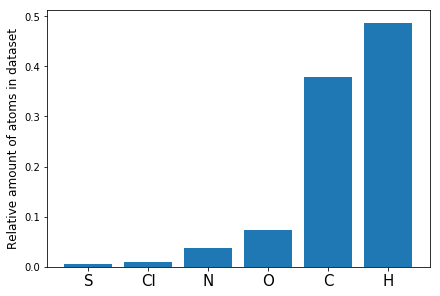

In [12]:
elements=create_element_dict(data,amount=AMOUNT_OF_ELEM)

In [23]:
elements

{'I': 0, 'Br': 1, 'F': 2, 'S': 3, 'Cl': 4, 'N': 5, 'O': 6, 'C': 7, 'H': 8}

In [100]:
start_time = time.time()
conf_calc1,_=conformers_calc(data,elements,numConfs=NUM_CONFS)
print("--- 1 process %s seconds ---" % (time.time() - start_time))
start_time = time.time()
conf_calc, del_keys=conf_calc_pool(data,elements,numConfs=NUM_CONFS,proc_num=NUM_PROC)
print("--- %d processes %s seconds ---" % (NUM_PROC,(time.time() - start_time)))

molecule 0 / 99
--- 1 process 77.78251266479492 seconds ---
--- 8 processes 36.141114473342896 seconds ---


## Data loaders preparing

In [14]:
#gaussian blur 3D cordinate transformation
#input - molecule - dictionary{atom:[(x1,x2,x3),...]}
#sigma - parameter of kernel

def gaussian_blur(molecule,elements,sigma=2,dimx=70,dx=0.5,kern_dim=50):
    from math import floor
    
    dimelem=len(elements)
    cube=torch.zeros((dimx,dimx,dimx,dimelem))
    
    #build the kernel
    x = torch.arange(-kern_dim/4,kern_dim/4,dx)
    y = torch.arange(-kern_dim/4,kern_dim/4,dx)
    z = torch.arange(-kern_dim/4,kern_dim/4,dx)
    xx, yy, zz = torch.meshgrid((x,y,z))
    kernel = torch.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2))
    
    for atom in molecule.keys():
        
        num_atom=elements[atom]
        
        for x0,y0,z0 in molecule[atom]:
            
            x_range=[max(floor(x[0]/dx+x0/dx+dimx/2),0),min(floor(x[-1]/dx+x0/dx+dimx/2+1),cube.shape[0])]
            y_range=[max(floor(y[0]/dx+y0/dx+dimx/2),0),min(floor(y[-1]/dx+y0/dx+dimx/2+1),cube.shape[1])]
            z_range=[max(floor(z[0]/dx+z0/dx+dimx/2),0),min(floor(z[-1]/dx+z0/dx+dimx/2+1),cube.shape[2])]
            coord_ranges=[x_range,y_range,z_range]
            for i in range(3):
                if coord_ranges[i][1]-coord_ranges[i][0]>50:
                    coord_ranges[i][1]=coord_ranges[i][0]+50
            cube_part=cube[coord_ranges[0][0]:coord_ranges[0][1],
                           coord_ranges[1][0]:coord_ranges[1][1],
                           coord_ranges[2][0]:coord_ranges[2][1],num_atom]
            
            kern_ranges=[[],[],[]]
            for i in range(3):
                if coord_ranges[i][0]==0:
                    kern_ranges[i].append(kern_dim-cube_part.shape[i])
                else:
                    kern_ranges[i].append(0)
                if coord_ranges[i][1]==cube.shape[i]:
                    kern_ranges[i].append(cube_part.shape[i])
                else:
                    kern_ranges[i].append(kern_dim)
                    
            cube_part=cube_part+kernel[kern_ranges[0][0]:kern_ranges[0][1],
                                       kern_ranges[1][0]:kern_ranges[1][1],
                                       kern_ranges[2][0]:kern_ranges[2][1]]
            
            cube[coord_ranges[0][0]:coord_ranges[0][1],
                 coord_ranges[1][0]:coord_ranges[1][1],
                 coord_ranges[2][0]:coord_ranges[2][1],num_atom]=cube_part

    return cube

In [32]:
#waves 3D cordinate transformation
#input - molecule - dictionary{atom:[(x1,x2,x3),...]}
#sigma - parameter of kernel

def waves(molecule,elements,sigma=1,dimx=70,dx=0.5,kern_dim=50):
    from math import floor
    omega=1/sigma
    dimelem=len(elements)
    cube=torch.zeros((dimx,dimx,dimx,dimelem))
    
    #build the kernel
    x = torch.arange(-kern_dim/4,kern_dim/4,dx)  
    y = torch.arange(-kern_dim/4,kern_dim/4,dx)
    z = torch.arange(-kern_dim/4,kern_dim/4,dx)
    xx, yy, zz = torch.meshgrid((x,y,z))
    kernel = np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2))*np.cos(2*np.pi*omega*np.sqrt(xx**2+yy**2+zz**2))
    
    for atom in molecule.keys():
        num_atom=elements[atom]
        
        for x0,y0,z0 in molecule[atom]:
            
            x_range=[max(floor(x[0]/dx+x0/dx+dimx/2),0),min(floor(x[-1]/dx+x0/dx+dimx/2+1),cube.shape[0])]
            y_range=[max(floor(y[0]/dx+y0/dx+dimx/2),0),min(floor(y[-1]/dx+y0/dx+dimx/2+1),cube.shape[1])]
            z_range=[max(floor(z[0]/dx+z0/dx+dimx/2),0),min(floor(z[-1]/dx+z0/dx+dimx/2+1),cube.shape[2])]
            coord_ranges=[x_range,y_range,z_range]
            for i in range(3):
                if coord_ranges[i][1]-coord_ranges[i][0]>50:
                    coord_ranges[i][1]=coord_ranges[i][0]+50
            cube_part=cube[coord_ranges[0][0]:coord_ranges[0][1],
                           coord_ranges[1][0]:coord_ranges[1][1],
                           coord_ranges[2][0]:coord_ranges[2][1],num_atom]
            
            kern_ranges=[[],[],[]]
            for i in range(3):
                if coord_ranges[i][0]==0:
                    kern_ranges[i].append(kern_dim-cube_part.shape[i])
                else:
                    kern_ranges[i].append(0)
                if coord_ranges[i][1]==cube.shape[i]:
                    kern_ranges[i].append(cube_part.shape[i])
                else:
                    kern_ranges[i].append(kern_dim)
                    
            cube_part=cube_part+kernel[kern_ranges[0][0]:kern_ranges[0][1],
                                       kern_ranges[1][0]:kern_ranges[1][1],
                                       kern_ranges[2][0]:kern_ranges[2][1]]
            
            cube[coord_ranges[0][0]:coord_ranges[0][1],
                 coord_ranges[1][0]:coord_ranges[1][1],
                 coord_ranges[2][0]:coord_ranges[2][1],num_atom]=cube_part
            
    return cube

### Debugging

In [43]:
#input:
#description - [atom name,x,y,z]
#elements - dictionary{element: number}
#dim - amount of grid points, dx - grid primitive cell size

#output:
#cube dimx*dimx*dimx*amount of zeros and ones

def creating_cube(elements, description, dimx=70, dx=0.5):
    dimelem=len(elements.keys())
    cube=torch.zeros((dimx,dimx,dimx,dimelem))
    for atom in description.keys():
        for x,y,z in description[atom]:
            xnum=int(dimx/2+x/dx)
            ynum=int(dimx/2+y/dx)
            znum=int(dimx/2+z/dx)
            cube[xnum][ynum][znum][elements[atom]]=1
    return cube

In [24]:
elements

{'S': 0, 'Cl': 1, 'N': 2, 'O': 3, 'C': 4, 'H': 5}

##### Visualization

In [17]:
#creating string for dx pymol file

class VolToDx():
#     s = StringIO()
    str ="""object 1 class gridpositions counts {xlen} {ylen} {zlen}
origin    {OrX} {OrY} {OrZ}
delta  {dX} 0 0
delta  0 {dY} 0
delta  0 0 {dZ}
object 2 class gridconnections counts {xlen} {ylen} {zlen}
object 3 class array type double rank 0 items {length} data follows
{records}
    """
    def __init__(self):
        pass
    def __call__(self, *args, **kwargs):
        volume = kwargs['volume']
        xlen,ylen,zlen = volume.shape
        try:
            (OrX, OrY, OrZ) = kwargs['origin']
            (dX, dY, dZ) = kwargs['dsteps']
        except:
            raise NotImplementedError() #FixMe: !!!

        assert type(volume) == np.ndarray
        length = np.prod(volume.shape)
        records = ""
        flatten = volume.flatten()
        for i in range(1,length+1):
            records += str(flatten[i-1]) + " "
            if i % 3 == 0 and i!=length: records += "\n"
        #records = np.savetxt(self.s,volume.reshape(3,-1),delimiter=" ")
        list_of_variables = ["xlen","ylen","zlen","OrX", "OrY", "OrZ","dX","dY","dZ","length","records"]
        params = {}
        for k in list_of_variables: params[k] = locals()[k]
#        print(params)
        return self.str.format(**params)

In [34]:
#plot colored 2D projection of molecules
def molecule_visualization2D(minibatch2D):
    for batch in minibatch2D:
        plt.imshow(batch,interpolation='none',cmap='rainbow')
        plt.colorbar()
        plt.show()

In [19]:
volume=waves(conf_calc['smiles0']['conformer1']['coordinates'],elements,sigma=6)

KeyError: 'smiles0'

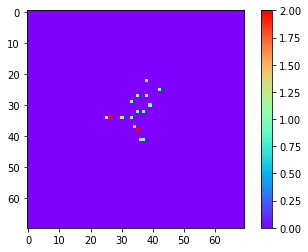

In [45]:
cube=creating_cube(elements,conf_calc['CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)cc1'][1]['coordinates'])
cube=cube[:,:,:,elements['C']].numpy()
cube=cube.sum(axis=2)
molecule_visualization2D([cube])

In [32]:
s = VolToDx()(**{'volume':volume[:,:,:,1].squeeze().numpy(),'origin':np.array([-17.5,-17.5,-17.5]),'dsteps':np.array([0.5,0.5,0.5])})
f=open('molecule.dx','w')
f.write(s)
f.close()

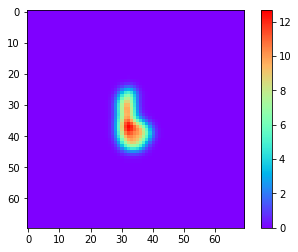

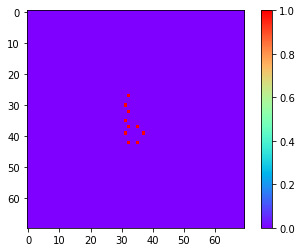

C[n+]1c2cc(N)ccc2cc2ccc(N)cc21


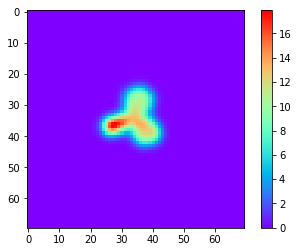

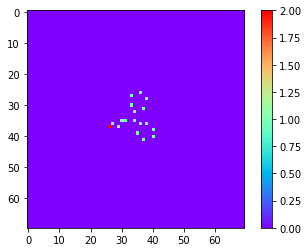

O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(Br)c([O-])c(Br)cc12


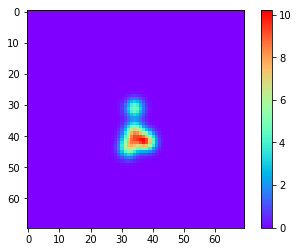

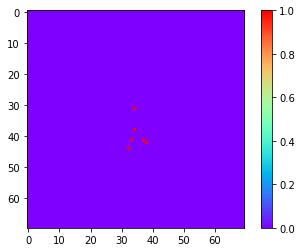

CCN(CC)C(=S)SSC(=S)N(CC)CC


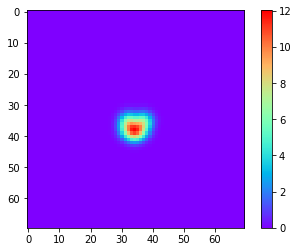

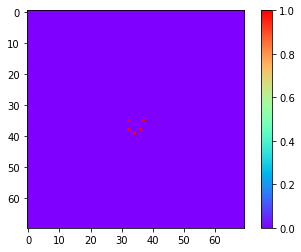

O=C(CCl)c1ccc(Cl)cc1Cl


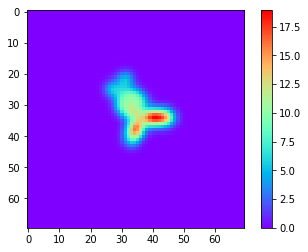

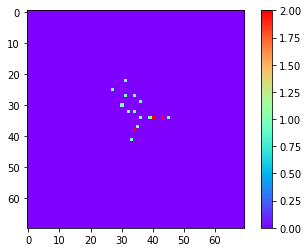

CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)cc1


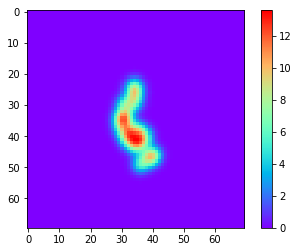

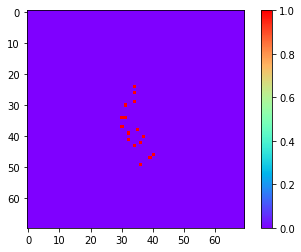

CCCCCCCCNC(C)C(O)c1ccc(SC(C)C)cc1


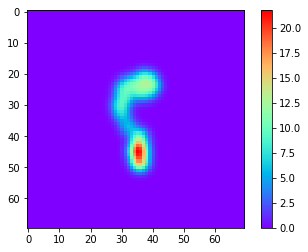

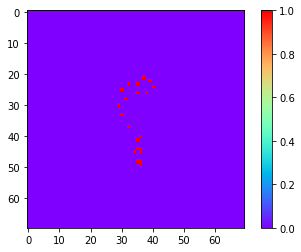

O[C@@H](CNC[C@H](O)[C@H]1CCc2cc(F)ccc2O1)[C@@H]1CCc2cc(F)ccc2O1


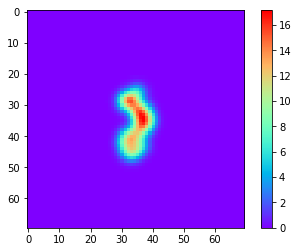

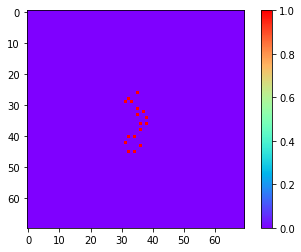

CC(C)(C)CC(C)(C)c1ccc(O)c(Cc2ccc(Cl)cc2Cl)c1


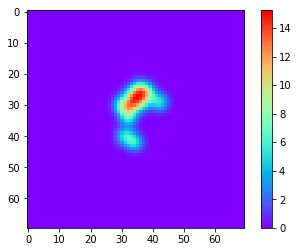

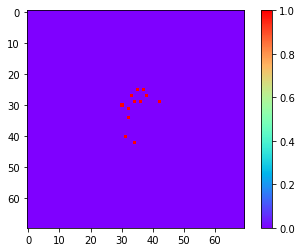

CCCCCNC(=N)N/N=C/c1c[nH]c2ccc(OC)cc12


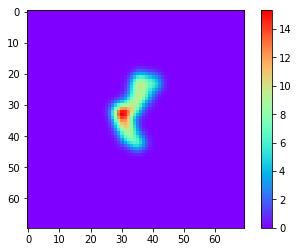

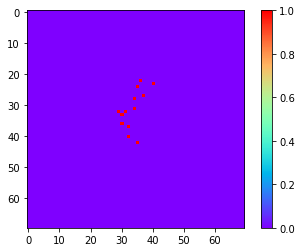

CCCCCCCCCCCCCC[N+](C)(C)C


In [20]:
for smile in list(conf_calc.keys())[:10]:
    volume=gaussian_blur(conf_calc[smile][0]['coordinates'],elements,sigma=1)
    cube=creating_cube(elements,conf_calc[smile][0]['coordinates'])
    volnp=volume[:,:,:,elements['C']].numpy()
    volnp=volnp.sum(axis=2)
    molecule_visualization2D([volnp])
    cube=cube[:,:,:,elements['C']].numpy()
    cube=cube.sum(axis=2)
    molecule_visualization2D([cube])
    print(smile)

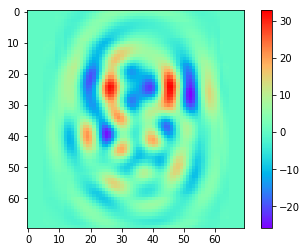

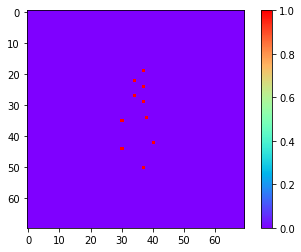

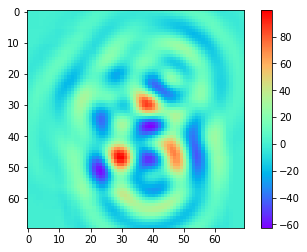

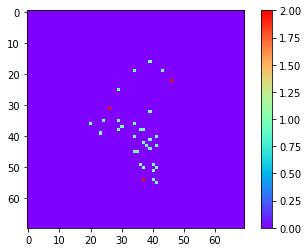

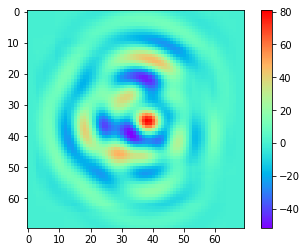

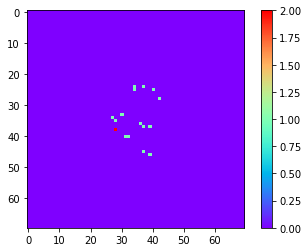

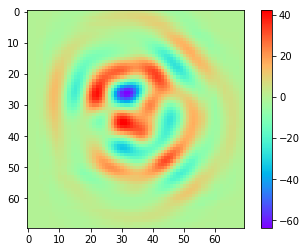

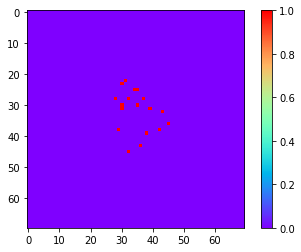

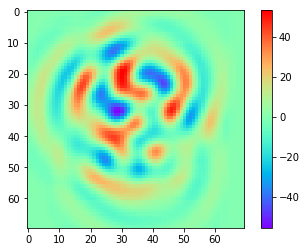

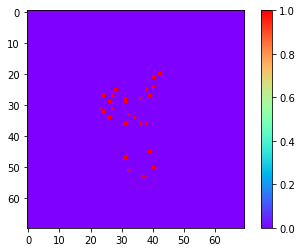

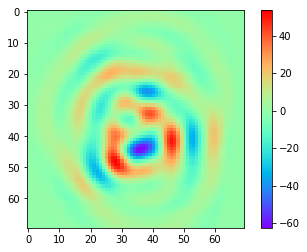

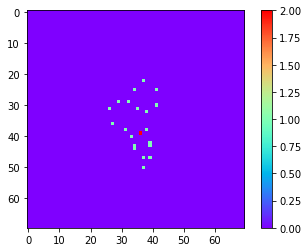

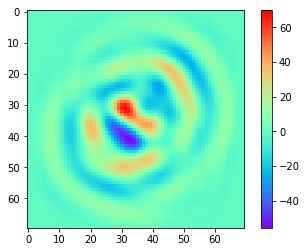

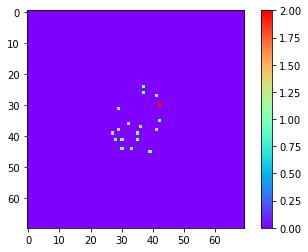

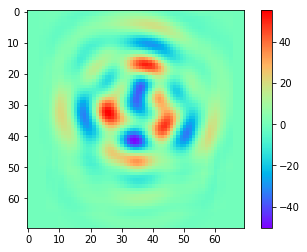

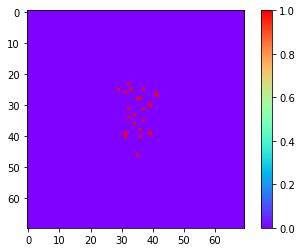

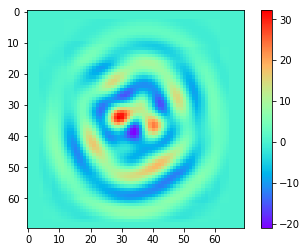

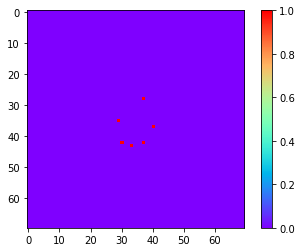

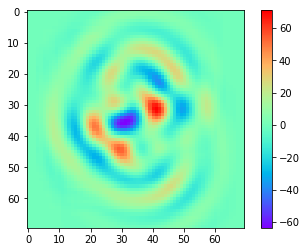

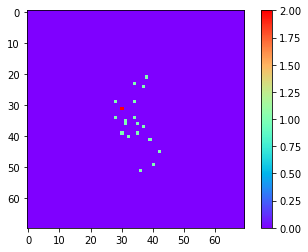

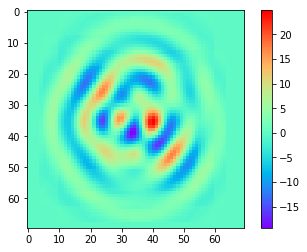

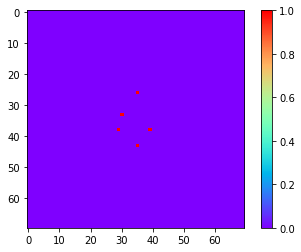

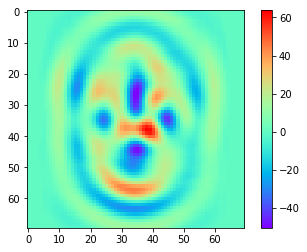

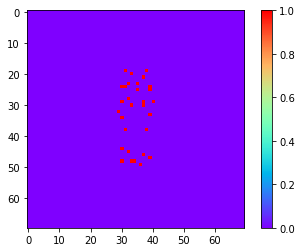

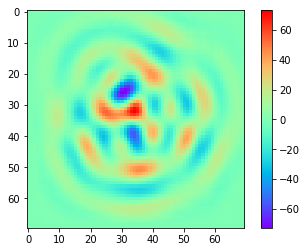

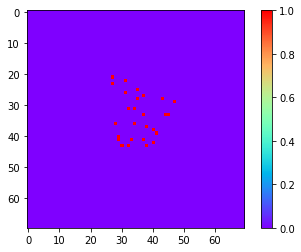

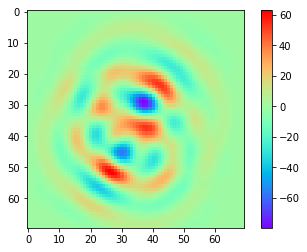

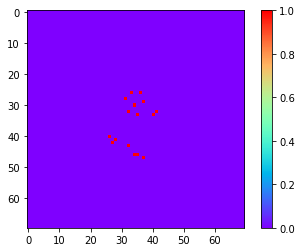

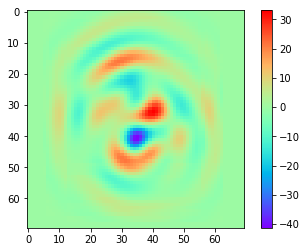

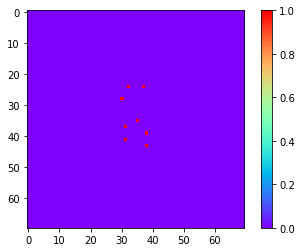

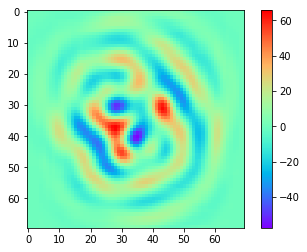

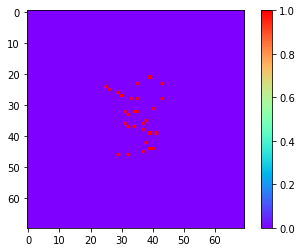

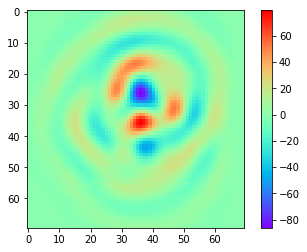

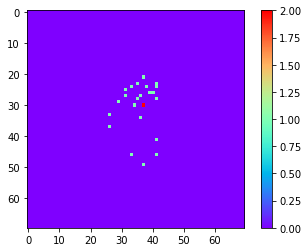

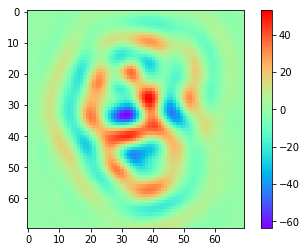

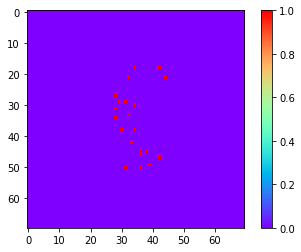

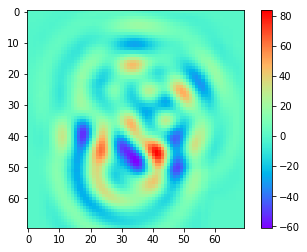

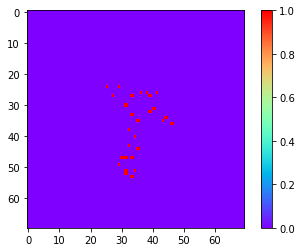

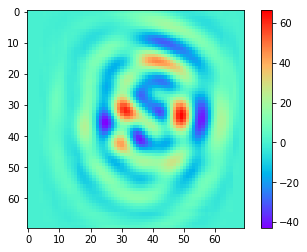

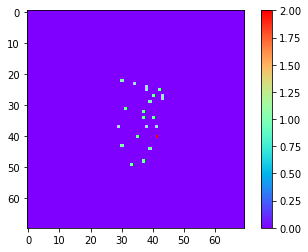

In [23]:
for smile in list(conf_calc.keys())[100:120]:
    volume=waves(conf_calc[smile][0]['coordinates'],elements,sigma=6)
    cube=creating_cube(elements,conf_calc[smile][0]['coordinates'])
    volnp=volume[:,:,:,elements['H']].numpy()
    volnp=volnp.sum(axis=2)
    molecule_visualization2D([volnp])
    cube=cube[:,:,:,elements['H']].numpy()
    cube=cube.sum(axis=2)
    molecule_visualization2D([cube])


## Creating dataloaders

In [23]:
def reading_sql_row(smiles,filename='tox21_conformers.db'):
        conf_calc={}
        conn = sqlite3.connect(filename)
        c = conn.cursor()
        for row in c.execute('SELECT * FROM tox WHERE smile=?',smiles):
            smile, conformer,energy,type_of_atom,x,y,z = row
            if smile in conf_calc.keys():
                if conformer in conf_calc[smile].keys():
                    conf_calc[smile][conformer]['energy']=energy
                    if 'coordinates' in conf_calc[smile][conformer].keys():
                        if type_of_atom in conf_calc[smile][conformer]['coordinates'].keys():
                            conf_calc[smile][conformer]['coordinates'][type_of_atom].append((x,y,z))
                        else:
                            conf_calc[smile][conformer]['coordinates'][type_of_atom]=[]
                    else:
                        conf_calc[smile][conformer]['coordinates']={}
                else:
                    conf_calc[smile][conformer]={}

            else:
                conf_calc[smile]={}
        conn.close()
        return conf_calc

In [24]:
#class of dataset created by gauss transformation
class Gauss_dataset(td.Dataset):
    def __init__(self,label_dict,elements,indexing, sigma=1,dim=70,dx=0.5,kern_dim=50,filename='tox21_conformers.db'):
        self.filename=filename
        self.Ys=label_dict
        self.elements=elements
        self.indexing = indexing
        self.sigma=sigma
        self.dim=dim
        self.dx=dx
        self.kern_dim=kern_dim

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.indexing.keys())

    def __getitem__(self, index):
        'Generates one sample of data'

        smiles=self.indexing[index]
        
        y= label_dict[smiles]
#         y=torch.from_numpy(y)
        self.Xs=reading_sql_row(smiles,filename=self.filename)
        description=self.Xs[smiles][conformer_choice(self.Xs[smiles])]['coordinates']
        X = gaussian_blur(description,elements,sigma=self.sigma,dimx=self.dim,dx=self.dx,kern_dim=self.kern_dim)
        
        return X, y
   

In [ ]:
#class of dataset created by gauss transformation
class Gauss_dataset(td.Dataset):
    def __init__(self,conf_calc,label_dict,elements,indexing, sigma=1,dim=70,dx=0.5,kern_dim=50):
        self.Xs=conf_calc
        self.Ys=label_dict
        self.elements=elements
        self.indexing = indexing
        self.sigma=sigma
        self.dim=dim
        self.dx=dx
        self.kern_dim=kern_dim

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.indexing.keys())

    def __getitem__(self, index):
        'Generates one sample of data'

        smiles=self.indexing[index]
        
        y= label_dict[smiles]
#         y=torch.from_numpy(y)

        description=self.Xs[smiles][conformer_choice(self.Xs[smiles])]['coordinates']
        X = gaussian_blur(description,elements,sigma=self.sigma,dimx=self.dim,dx=self.dx,kern_dim=self.kern_dim)
        
        return X, y

In [39]:
#class of dataset created by waves transformation
class Waves_dataset(td.Dataset):
    def __init__(self,conf_calc,label_dict,elements,indexing, sigma=1,dim=70,dx=0.5,kern_dim=50):
        self.Xs=conf_calc
        self.Ys=label_dict
        self.elements=elements
        self.indexing = indexing
        self.sigma=sigma
        self.dim=dim
        self.dx=dx
        self.kern_dim=kern_dim

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.indexing.keys())

    def __getitem__(self, index):
        'Generates one sample of data'

        smiles=self.indexing[index]
        print (smiles)
        y= label_dict[smiles]
#         y=torch.from_numpy(y)

        description=self.Xs[smiles][conformer_choice(self.Xs[smiles])]['coordinates']
        X = waves(description,elements,sigma=self.sigma,dimx=self.dim,dx=self.dx,kern_dim=self.kern_dim)
        
        return X, y

### Debugging

In [25]:
training_set_gauss = Gauss_dataset(label_dict,elements,indexing,sigma=3)
training_generator_gauss = td.DataLoader(training_set_gauss)

In [40]:
training_set_waves = Waves_dataset(conf_calc,label_dict,elements,indexing,sigma=6)
training_generator_waves = td.DataLoader(training_set_waves)

C[n+]1c2cc(N)ccc2cc2ccc(N)cc21


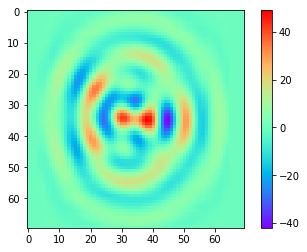

O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(Br)c([O-])c(Br)cc12


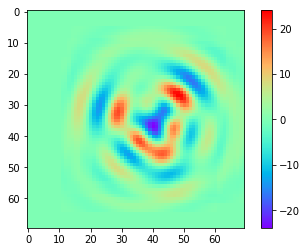

CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)cc1


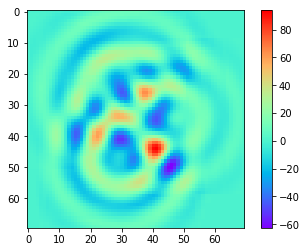

CCCCCCCCNC(C)C(O)c1ccc(SC(C)C)cc1


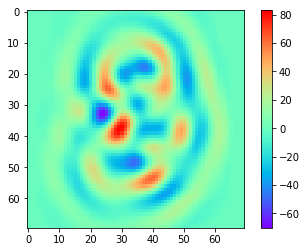

CCN(CC)C(=S)SSC(=S)N(CC)CC


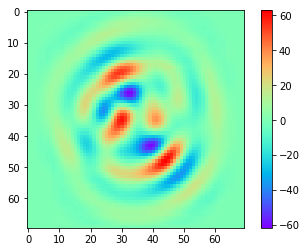

CCCCCCOc1ccc(C(=N)N(CCCC)CCCC)c2ccccc12


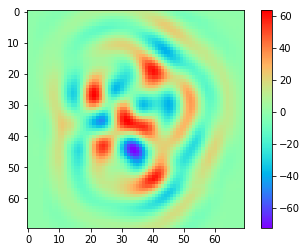

COCC(=O)O[C@]1(CCN(C)CCCc2nc3ccccc3[nH]2)CCc2cc(F)ccc2[C@@H]1C(C)C


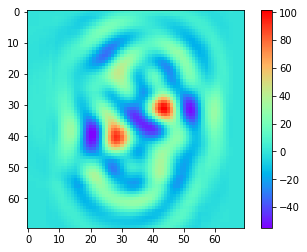

CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N)NCC(CC)CCCC


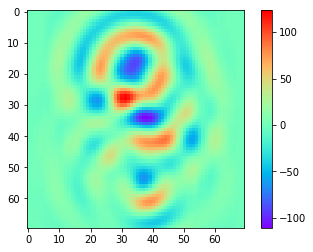

O[C@@H](CNC[C@H](O)[C@H]1CCc2cc(F)ccc2O1)[C@@H]1CCc2cc(F)ccc2O1


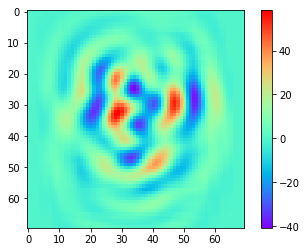

CC(C)(C)CC(C)(C)c1ccc(O)c(Cc2ccc(Cl)cc2Cl)c1


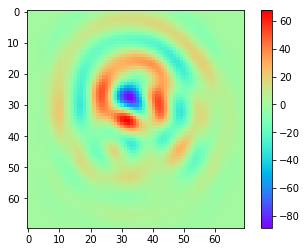

CCCCCNC(=N)N/N=C/c1c[nH]c2ccc(OC)cc12


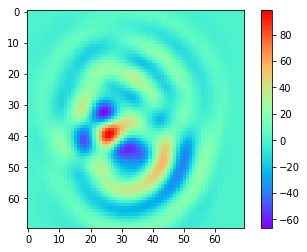

O=C(CCl)c1ccc(Cl)cc1Cl


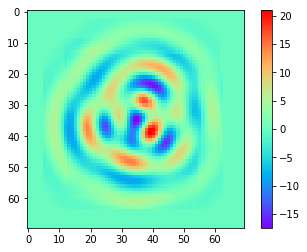

C[C@@H]1O[C@@H](O[C@H]2C[C@@H](O)[C@]3(CO)[C@H]4[C@H](O)C[C@]5(C)[C@@H](C6=CC(=O)OC6)CC[C@]5(O)[C@@H]4CC[C@]3(O)C2)[C@H](O)[C@H](O)[C@H]1O


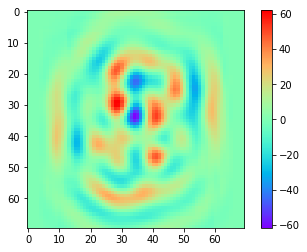

CCCCCCCCCCCCCC[N+](C)(C)C


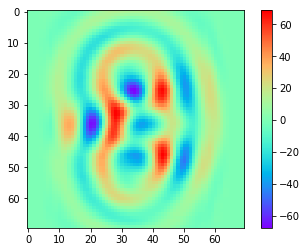

CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1


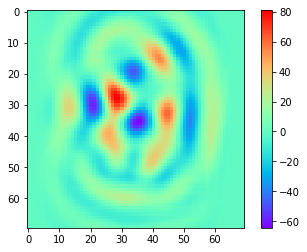

In [46]:
dataloader_iterator = iter(training_generator_waves)
for i in range(15):
    volume, target = next(dataloader_iterator)
#     except StopIteration:
#         dataloader_iterator = iter(training_generator_waves)
#         volume, target = next(dataloader_iterator)
    volnp=volume[:,:,:,:,elements['H']].squeeze().numpy()
    volnp=volnp.sum(axis=2)
    molecule_visualization2D([volnp])
#     print(smile)
#     s = VolToDx()(**{'volume':volume[:,:,:,:,1].squeeze().numpy(),'origin':np.array([-17.5,-17.5,-17.5]),'dsteps':np.array([0.5,0.5,0.5])})

In [106]:
f=open('molecule.dx','w')
f.write(s)
f.close()